In [1]:
import acoular
import matplotlib.pyplot as pl
import ipywidgets as ipw
import numpy as np
from glob import glob
from os import path
import pylab as plt
import math as m


In [2]:
#Einlesen der Micgeo
micgeofile = 'mic_geo.xml'
mg = acoular.MicGeom(from_file=micgeofile)
mg.mpos[0] = - mg.mpos[0] #Spiegeln
mg.mpos[0] = mg.mpos[0] + 0.419 #Versatz
#print(mg.mpos)

#Rotationsmatrix
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])

for i in range (64):
    Punkt = [mg.mpos[0][i],mg.mpos[1][i],mg.mpos[2][i]]
    rot = np.array(Punkt * Rx(np.radians(-45)))
    #print(rot[0][0])
    mg.mpos[0][i] = rot[0][0]
    mg.mpos[1][i] = rot[0][1]
    mg.mpos[2][i] = rot[0][2]
mg.mpos[1] = - mg.mpos[1]

#plt.ion()
#plt.plot(mg.mpos[2],mg.mpos[1],'o')

Einlesen der Daten:

In [98]:
# Umgebung definieren (Medium, Strömung etc)
t = 23.6
e = acoular.Environment(c = 20.05*np.sqrt(273+t))

#Einlesen der Daten:
#ts = acoular.TimeSamples( name='Messungen WFS\msm_025.h5' )
ts = acoular.TimeSamples( name='Messungen_WFS/msm_015.h5' )


#Grid erstellen


#============== Messung 1,2,3,4,5,15,16,17,18,19,20,23,24,25,36,27,28 ==============
rg = acoular.RectGrid( x_min=-1.0, x_max=1.0, 
                       y_min=-1.0, y_max=1.0, 
                       z=2, 
                       increment=0.01 )

#============== Messung 6,7,8,9,21,22 ==============
#rg = acoular.RectGrid( x_min=-6, x_max=6, 
#                       y_min=-6, y_max=6, 
#                       z=6, 
#                       increment=0.01 )   

#============== Messung 11, 12, 13, 14 ==============
#rg = acoular.RectGrid( x_min=-10.0, x_max=10.0, 
#                       y_min=-10.0, y_max=10.0, 
#                       z=9, 
#                       increment=0.01 )                 


#Steering Vector
st = acoular.SteeringVector( grid=rg, 
                             mics=mg, 
                             ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'classic') # ???

#Spectrum erstellen:
ps = acoular.PowerSpectra( time_data=ts, 
                           block_size=128,
                           freq_range=[1000, 20000],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb = acoular.BeamformerBase( freq_data=ps, 
                             steer=st )

[('msm_015_cache.h5', 1)]


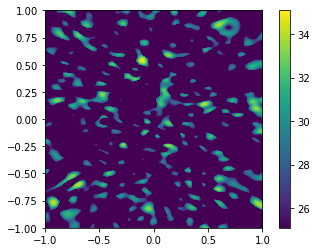

In [99]:
# 500 1000 2000
# 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300 8000 10000 12500 16000 20000


pm = bb.synthetic(8000, 0) # 0=Freq, 1=Okt, 3=Terz
Lm = acoular.L_p( pm )

plt.figure()
plt.imshow( Lm.T, 
            origin='lower', 
            vmin=Lm.max()-10, 
            extent=rg.extend(), 
            interpolation='bicubic')  # bicubic vs nearest? -> bicubic beschoenigt
plt.colorbar()
#plt.savefig('Plots/%s_terz10000Hz'%ts.name[14:21], dpi = 300, format='png')
plt.show()

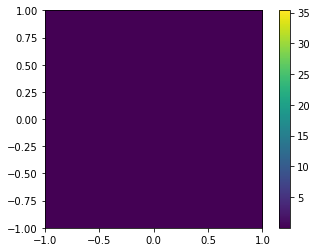

In [14]:

'''
map_z = sum(pm,2)
map_y = sum(pm,1)
map_x = sum(pm,0)

plt.figure()
plt.imshow( map_x.T, 
            origin='lower', 
            vmin=Lm.max()-10, 
            extent=rg.extend(), 
            interpolation='bicubic')  # bicubic vs nearest?
plt.colorbar()
#plt.savefig('Plots/%s_okt_1600'%ts.name[14:21], dpi = 300, format='png')
plt.show()

'''

In [ ]:
from acoular import __file__ as bpath, L_p, MicGeom, PowerSpectra,\
RectGrid3D, BeamformerBase, BeamformerCleansc, \
SteeringVector, WNoiseGenerator, PointSource, SourceMixer

from numpy import mgrid, arange, array, arccos, pi, cos, sin, sum
import mpl_toolkits.mplot3d
from pylab import figure, show, scatter, subplot, imshow, title, colorbar,\
xlabel, ylabel

b = acoular.BeamformerCleansc(freq_data=ps, steer=st)

g = acoular.RectGrid3D(x_min=-0.5, x_max=0.5, 
                       y_min=-0.5, y_max=0.5, 
                       z_min=1.5, z_max=2.5, 
                       increment=0.02)

map = b.synthetic(2000,1)

<ipython-input-75-858483a2851c>:1: Warning: Queried frequency (1500 Hz) not in set of discrete FFT sample frequencies. Using frequency 1600 Hz instead.
  map = bb.synthetic(1500, 0)


TypeError: Invalid shape (401,) for image data

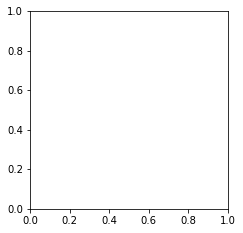

In [75]:
map = bb.synthetic(1500, 0)
fig=figure(1,(8,8))

subplot(221)
map_z = sum(map,0)
mx = L_p(map_z.max())
imshow(L_p(map_z.T), vmax=mx, vmin=mx-20, origin='lower', interpolation='nearest', 
       extent=(g.x_min, g.x_max, g.y_min, g.y_max))
xlabel('x')
ylabel('y')
title('Top view (xy)' )

subplot(223)
map_y = sum(map,1)
imshow(L_p(map_y.T), vmax=mx, vmin=mx-20, origin='upper', interpolation='nearest', 
       extent=(g.x_min, g.x_max, -g.z_max, -g.z_min))
xlabel('x')
ylabel('z')
title('Side view (xz)' )

subplot(222)
map_x = sum(map,0)
imshow(L_p(map_x), vmax=mx, vmin=mx-20, origin='lower', interpolation='nearest', 
       extent=(-g.z_min, -g.z_max,g.y_min, g.y_max))
xlabel('z')
ylabel('y')
title('Side view (zy)' )
colorbar()

In [67]:
ax0 = fig.add_subplot((224), projection='3d')
ax0.scatter(mg.mpos[0],mg.mpos[1],-mg.mpos[2])
#source_locs=array([p1.loc,p2.loc,p3.loc]).T
#ax0.scatter(source_locs[0],source_locs[1],-source_locs[2])
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel('z')
ax0.set_title('Setup (mic and source positions)')
#plt.show()

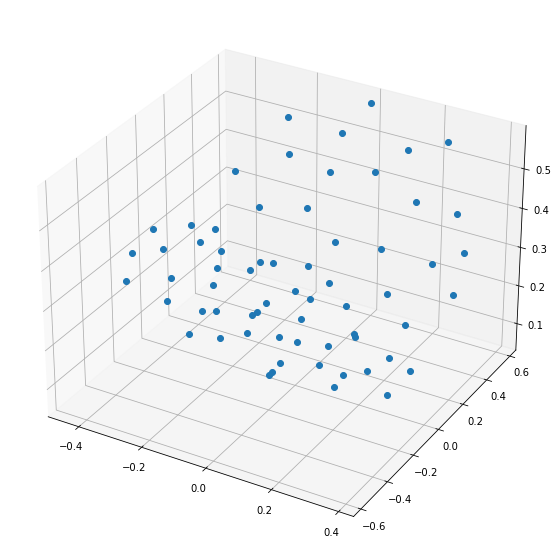

In [76]:
fig,ax = plt.subplots(1,1,figsize=(10,10),sharey=True)
ax = plt.axes(projection='3d')
ax.plot3D(mg.mpos[0], mg.mpos[1], mg.mpos[2], 'o')